### Simulazione - Driver


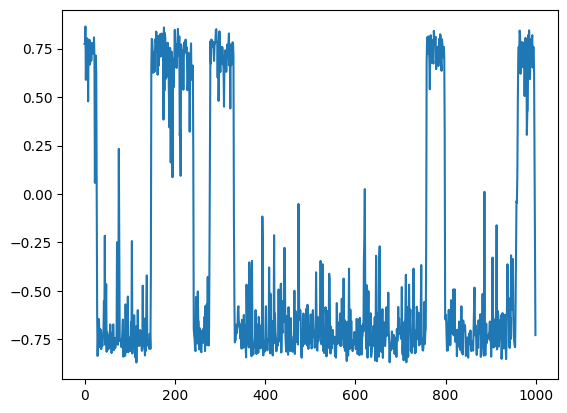

In [2]:
from ising_byme import TriangularLattice, IsingTriangular, MetropolisMC
from f2py_jit import jit
import numpy as np
import matplotlib.pyplot as plt
import os
if not os.path.exists('data'):
    os.makedirs('data')

# Definisco la geometria del sistema: in questo caso triangolare 2D
Lx = Ly = 40
lat = TriangularLattice(Lx, Ly, a=1.0)
# Inizializzo il sistema: Ising su reticolo triangolare 
model = IsingTriangular(lat, J=1.0, T=3.6, rng=np.random.default_rng())  
f90 = jit('mc_metropolis_ising.f90', flags='-O3 -ffast-math')

# Inizializzo la simulazione montecarlo, con i suoi metodi
mc = MetropolisMC(model,coordination=6)
mc.set_temperature(3.6)

nmcs = 100000
measure_step = 100
nequil = 20000
acc,acc_rate,E_array,M_array,acc_sum_out,nsamples_out,spins_array = mc.driver(nequil,nmcs,measure_step)

spins_array_i8 = spins_array.astype(np.int8) # sono solo +-1, tanto vale la minima rappresentazione
# Salvo i dati su disco per renderli più gestibili
filename_energy = f'data/Energy.npy'
filename_magnetization = f'data/Magnetization.npy'
filename_spin =f'data/Spins.npy'

np.save(filename_energy,E_array)
np.save(filename_magnetization,M_array)
np.save(filename_spin,spins_array_i8)
plt.plot(np.arange(len(M_array)),M_array)




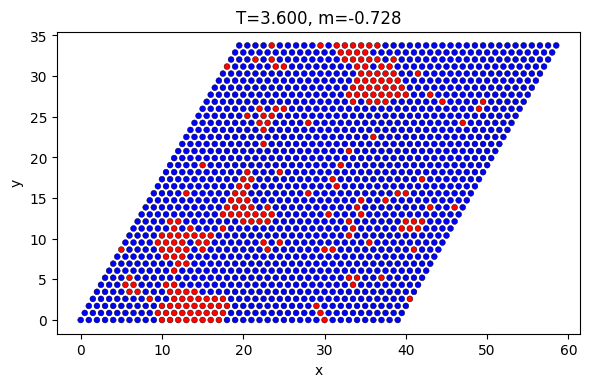

In [3]:
pos = model.lattice.positions            # (N, 2)
snaps = spins_array                        # spins_array dal driver: atteso (N, nsamples)
s = snaps[:, -1]                         # vettore di spin (N,)
m = s.mean()                             # magnetizzazione per spin

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(pos[:,0], pos[:,1],
            c=s, vmin=-1, vmax=1, cmap='bwr',
            s=18, edgecolors='black', linewidths=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"T={model.T:.3f}, m={m:.3f}")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

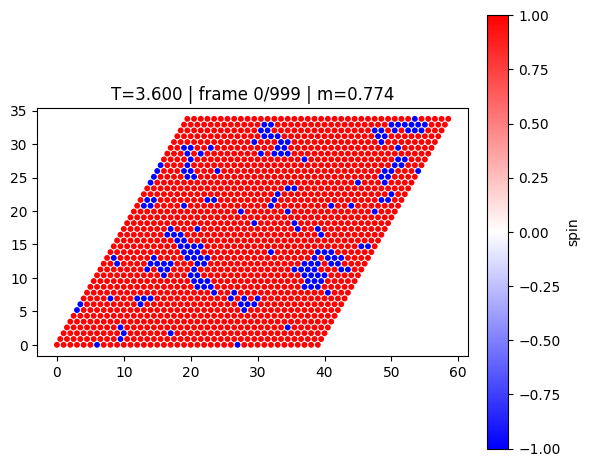

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

# Dopo aver eseguito la simulazione:
# acc, acc_rate, E_array, M_array, acc_sum_out, nsamples_out, spins_array = mc.driver(nequil, nmcs, measure_step)

pos   = model.lattice.positions                 # (N, 2)
snaps = spins_array                              # (N, nsamples)

# Se per caso è (nsamples, N), trasponi:
if snaps.shape[0] != model.lattice.N and snaps.shape[1] == model.lattice.N:
    snaps = snaps.T

N, nsamples = snaps.shape
assert N == model.lattice.N

# (Opzionale) sottocampiona i frame per alleggerire l'animazione
stride = 1                 # es. 2 o 5 se vuoi meno frame
frames = range(0, nsamples, stride)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(
    pos[:, 0], pos[:, 1],
    c=snaps[:, 0], vmin=-1, vmax=1, cmap='bwr',
    s=18, edgecolors='none'   # niente bordi = molto più veloce
)
ax.set_aspect('equal', adjustable='box')
cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('spin')
title = ax.set_title(f"T={model.T:.3f} | frame 0/{nsamples-1} | m={snaps[:,0].mean():.3f}")

def init():
    sc.set_array(snaps[:, 0])
    title.set_text(f"T={model.T:.3f} | frame 0/{nsamples-1} | m={snaps[:,0].mean():.3f}")
    return sc, title

def update(f):
    s = snaps[:, f]
    sc.set_array(s)  # aggiorna i colori (gli spin)
    m = s.mean()
    title.set_text(f"T={model.T:.3f} | frame {f}/{nsamples-1} | m={m:.3f}")
    return sc, title

ani = animation.FuncAnimation(
    fig, update, frames=frames, init_func=init,
    blit=True, interval=50  # interval in ms; aumenta se scatta
)

plt.tight_layout()
plt.show()
ani.save("data/ising.gif", writer=PillowWriter(fps=20))